In [1]:
# GNU LESSER GENERAL PUBLIC LICENSE
# Version 3, 29 June 2007.
# Copyright (C) 2007 Free Software Foundation, Inc. <http://fsf.org/>.
# Everyone is permitted to copy and distribute verbatim copies of this 
# license document, but changing it is not allowed.

# The Transportation Simplex
## Automated Simulation in GIS
---

### James Gaboardi, 2016

---

### Primal: minimize the cost needed to ship units from supply facilities to demand facilities.
---

## $\text{Minimize}$
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\displaystyle \sum_{i \in I} \sum_{j \in J} c_{ij} x_{ij}$
## $\text{Subject To}$
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\displaystyle \sum_{j \in J} x_{ij} \leq S_i $&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\forall i \in I$
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\displaystyle \sum_{i \in I} x_{ij} \geq D_j $&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\forall j \in J$
## &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\displaystyle x_{ij} \geq 0 $&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\forall i \in I ; \forall j \in J$



-----

Adapted from:
- ***Daskin, M. S. 1995***. Network and Discrete Location: Models, Algorithms, and Applications. Hoboken, NJ, USA: John Wiley & Sons, Inc.

--------------------

## Imports & Set Up

In [29]:
# Imports
import pysal as ps
import geopandas as gpd
import numpy as np
import networkx as nx
from shapely.geometry import Point
import shapely
from collections import OrderedDict
import pandas as pd
import qgrid
import gurobipy as gbp
import time
import bokeh
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import output_notebook, output_file, show
from bokeh.models import (HoverTool, BoxAnnotation, GeoJSONDataSource, 
                          GMapPlot, GMapOptions, ColumnDataSource, Circle, 
                          DataRange1d, PanTool, WheelZoomTool, BoxSelectTool,
                          ResetTool, MultiLine)
import utm
import matplotlib.pyplot as plt
import matplotlib as mpl

# MatPlotLib for Visualizations inline
%matplotlib inline

# Local path on user's machine
path = '/Users/jgaboardi/Transport/Data/'
#path = 'path/to/data/'

# Set Random Seed
np.random.seed(850)

# Out inline notebook for Bokeh
output_notebook()

Loading BokehJS ...

## Data preparation and creation

### Reproject the street network with `GeoPandas`

In [3]:
# Waverly  Hills
streets = gpd.read_file(path+'Waverly_Trim/Waverly.shp')
streets.to_crs(epsg=2779, inplace=True) # NAD83(HARN) / Florida North
streets.to_file(path+'waverly/waverly.shp')
streets[:5]

,ACCESS_,ALIAS_NAME,BUILT_DATE,BUILT_STAT,CLASS,CONN_TYPE,COUNTY,EDIT_BY,EDIT_DATE,EDIT_TYPE,...,SOURCE,SPEED,STATUS,SUFFIX,TF_COST,THEOR_RANG,TRAVEL_FLA,TYPE,T_ELEV,geometry
0,None,SR - 61,None,BUILT,8,CONN,LEON,HAGESETHC,2014-02-26,O,...,DOP2008TFC,5,O,None,0.090264,N,2,RD,0,LINESTRING (623093.510832076 164171.1041567803...
1,None,SR - 61,None,BUILT,8,INTE,LEON,HAGESETHC,2014-02-26,O,...,FDOR2007TFC,25,O,None,0.017222,N,2,RD,0,LINESTRING (622515.1922320754 163214.635256776...
2,None,SR - 61,None,BUILT,8,CONN,LEON,HAGESETHC,2014-02-26,O,...,DOP2008TFC,5,O,None,0.091403,N,2,RD,0,LINESTRING (623548.0931320738 165478.253356780...
3,None,SR - 61,None,BUILT,8,CONN,LEON,HAGESETHC,2014-02-26,O,...,DOP2008TFC,5,O,None,0.090467,N,2,RD,0,LINESTRING (623167.8413320724 164328.903156780...
4,None,SR - 61,None,BUILT,8,CONN,LEON,HAGESETHC,2014-02-26,O,...,DOP2008TFC,5,O,None,0.089032,N,2,RD,0,LINESTRING (623546.4237320729 165409.808056779...


### Plot Waverly Hills

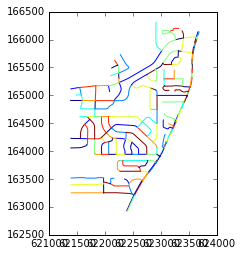

In [4]:
streets.plot()

### Instantiate Network and read in `WAVERLY.shp`

In [5]:
ntw = ps.Network(path+'waverly/waverly.shp')
shp_waverly = ps.open(path+'waverly/waverly.shp')

### Create Buffer of 200 meters

In [6]:
intial_buffer = streets.buffer(50)  #Buffer
intial_buffer[:5]

0    POLYGON ((623124.0407875385 164212.5102460865,...
1    POLYGON ((622546.5762248621 163255.235891574, ...
2    POLYGON ((623559.7869314271 165528.3883790929,...
3    POLYGON ((623200.6855916528 164368.5069398382,...
4    POLYGON ((623558.3641320666 165459.8080567809,...
dtype: object

### Plot Buffers of Individual Streets

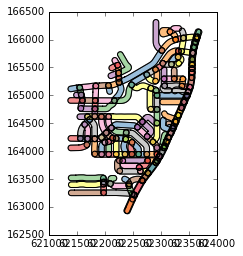

In [7]:
intial_buffer.plot()

### Create a Unary Union of the individual street buffers

In [8]:
union_buffer = intial_buffer.unary_union  #Buffer Union
union_buffer = gpd.GeoSeries(union_buffer)
union_buffer.crs = streets.crs
final_buffer = gpd.GeoDataFrame(union_buffer, crs=streets.crs)
final_buffer.columns = ['geometry']
final_buffer

,geometry
0,"POLYGON ((622537.3422082652 163117.6387178254,..."


### Plot the unary union buffer

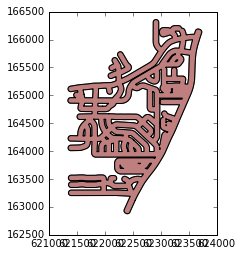

In [9]:
final_buffer.plot()

### Create 1000 random points within the bounds of `WAVERLY.shp`

In [10]:
np.random.seed(352)
x = np.random.uniform(shp_waverly.bbox[0], shp_waverly.bbox[2], 100)
np.random.seed(850)
y = np.random.uniform(shp_waverly.bbox[1], shp_waverly.bbox[3], 100)  
coords = zip(x,y)
coords = [shapely.geometry.Point(i) for i in coords]
sim_points = gpd.GeoDataFrame(coords)
sim_points.crs = streets.crs
sim_points.columns = ['geometry']
sim_points[:5]

,geometry
0,POINT (623388.4926405598 166286.4795721661)
1,POINT (622672.4092589854 162943.9994787998)
2,POINT (621913.3153830337 164903.3379650218)
3,POINT (621612.0857702466 164217.1288344094)
4,POINT (623414.8982675247 163698.4405537729)


### Plot the 1000 random 

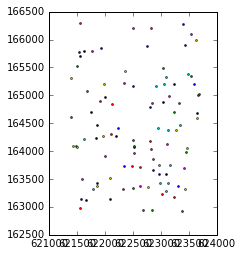

In [11]:
sim_points.plot()

### Create `GeoPandas` DF of the random points within the Unary Buffer

In [12]:
intersection = [final_buffer['geometry'].intersection(p) for p in sim_points['geometry']]
intersection = gpd.GeoDataFrame(intersection, crs=streets.crs)
intersection.columns = ['geometry']
intersection[:5]

,geometry
0,()
1,()
2,POINT (621913.3153830337 164903.3379650218)
3,POINT (621612.0857702466 164217.1288344094)
4,()


### Plot the points within the Unary Buffer

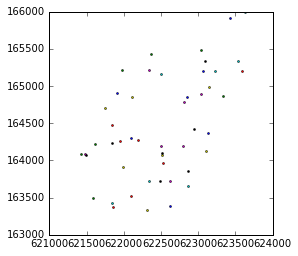

In [13]:
intersection.plot()

### Add only intersecting records to a list 

In [14]:
# Add records that are points within the buffer
point_in = []
for p in intersection['geometry']:
    if type(p) == shapely.geometry.point.Point:
        point_in.append(p)
point_in[:5]

### Create Simulated Supply and Demand

In [15]:
# Supply
supply_vector = np.random.randint(50, 200, 5)
supply_vector = supply_vector.reshape(len(supply_vector),1)
# Demand
demand_vector = np.random.randint(10, 100, 10)
demand_vector = demand_vector.reshape(len(demand_vector),1)

### Create shapefiles of unsnapped locations:  Keep first 5 for Supply facilities and last 10 for Demand facilities

In [16]:
# SUPPLY
supply_gdf = gpd.GeoDataFrame(point_in[:5], crs=streets.crs)
supply_gdf.columns = ['geometry']

# DEMAND
demand_gdf = gpd.GeoDataFrame(point_in[-10:], crs=streets.crs)
demand_gdf.columns = ['geometry']

########################################################    
# Write out .shps    
supply_gdf.to_file(path+'supply/supply.shp')
demand_gdf.to_file(path+'demand/demand.shp')

### Create dummy list to prepare for LatLon conversion

In [17]:
supply_locations = []
for i in supply_gdf['geometry']:
    supply_locations.append(i)
supply_locations = pd.DataFrame(supply_locations)    
supply_locations.columns = ['geometry']    
supply_locations = gpd.GeoDataFrame(supply_locations, crs=streets.crs)

demand_locations = []
for i in demand_gdf['geometry']:
    demand_locations.append(i)
demand_locations = pd.DataFrame(demand_locations)    
demand_locations.columns = ['geometry']    
demand_locations = gpd.GeoDataFrame(demand_locations, crs=streets.crs)

### Covert location to LatLon attributes

In [18]:
# Convert store SUPPLY locations to LatLon
supply_locations.to_crs(epsg=32616, inplace=True) # UTM 16N
supply_locations_LonLat_Dict = OrderedDict()
supply_locations_LonLat_List = []

for i,j in supply_locations['geometry'].iteritems():
    supply_locations_LonLat_Dict[supply_locations.index[i]] = utm.to_latlon(j.xy[0][-1], j.xy[1][-1], 16, 'N')  
    supply_locations_LonLat_List.append((utm.to_latlon(j.xy[0][-1], j.xy[1][-1], 16, 'N')))

supply_locations_Lat_List = []
supply_locations_Lon_List = []
    
for i in supply_locations_LonLat_List:
    supply_locations_Lat_List.append(i[0])
for i in supply_locations_LonLat_List:
    supply_locations_Lon_List.append(i[1])
# Add Columns of data
supply_gdf['ID'] = ['s'+str(num) for num in range(10001, len(supply_vector)+10001)]
supply_gdf['Units Supplied'] = supply_vector
supply_gdf['Lat'] = supply_locations_Lat_List
supply_gdf['Lon'] = supply_locations_Lon_List

# Convert store DEMAND locations to LatLon
demand_locations.to_crs(epsg=32616, inplace=True) # UTM 16N
demand_locations_LonLat_Dict = OrderedDict()
demand_locations_LonLat_List = []

for i,j in demand_locations['geometry'].iteritems():
    demand_locations_LonLat_Dict[demand_locations.index[i]] = utm.to_latlon(j.xy[0][-1], j.xy[1][-1], 16, 'N')  
    demand_locations_LonLat_List.append((utm.to_latlon(j.xy[0][-1], j.xy[1][-1], 16, 'N')))

demand_locations_Lat_List = []
demand_locations_Lon_List = []
    
for i in demand_locations_LonLat_List:
    demand_locations_Lat_List.append(i[0])
for i in demand_locations_LonLat_List:
    demand_locations_Lon_List.append(i[1])
# Add Columns of data

demand_gdf['ID'] = ['d'+str(num) for num in range(10001, len(demand_vector)+10001)]
demand_gdf['Units Demanded'] = demand_vector
demand_gdf['Lat'] = demand_locations_Lat_List
demand_gdf['Lon'] = demand_locations_Lon_List

#############################################################
# Write out .shps    
supply_gdf.to_file(path+'supply/supply.shp')
demand_gdf.to_file(path+'demand/demand.shp')

In [19]:
supply_gdf[:2]

,geometry,ID,Units Supplied,Lat,Lon
0,POINT (621913.3153830337 164903.3379650218),s10001,71,30.487267,-84.271757
1,POINT (621612.0857702466 164217.1288344094),s10002,156,30.481083,-84.274908


In [20]:
demand_gdf[:2]

,geometry,ID,Units Demanded,Lat,Lon
0,POINT (622615.3983850051 163718.8709875496),d10001,69,30.476570,-84.264470
1,POINT (623098.0732985543 164124.0125775343),d10002,15,30.480215,-84.259434


### Instaniate non-solution graphs to be drawn

In [21]:
# Roads and Nodes
graph_roads = nx.Graph()
# Clients
graph_supply = nx.Graph()
# Snapped Supply
snapped_supply = nx.Graph()
# Demand
graph_demand = nx.Graph()
# Snapped Demand
snapped_demand = nx.Graph()

### Instantiate and fill Supply and Demand point dictionaries

In [22]:
points_supply = {} 
points_demand = {}

sply = ps.open(path+'supply/supply.shp')
for idx, coords in enumerate(sply):
    graph_supply.add_node(idx)
    points_supply[idx] = coords
    graph_supply.node[idx] = coords
    
dmnd = ps.open(path+'demand/demand.shp')
for idx, coords in enumerate(dmnd):
    graph_demand.add_node(idx)
    points_demand[idx] = coords
    graph_demand.node[idx] = coords

### Snap Observations to NTW

In [23]:
# Snap
ntw.snapobservations(path+'supply/supply.shp', 
                     'simulated_supply', attribute=True)
ntw.snapobservations(path+'demand/demand.shp', 
                     'simulated_demand', attribute=True)

### Draw NTW, snapped coords, & random coords

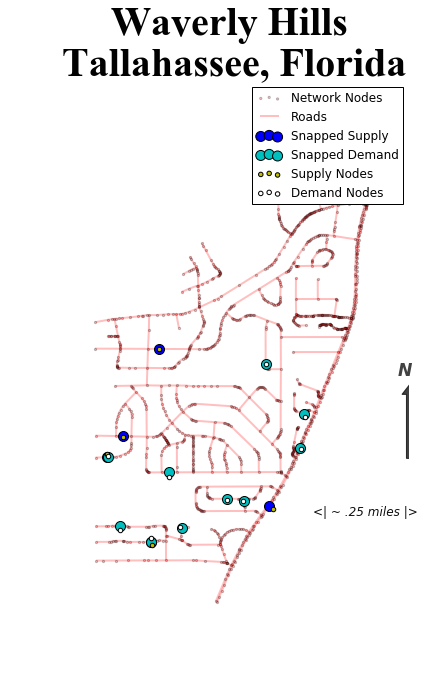

In [24]:
# Instantiate Figure
mpl.rcParams['figure.figsize']=5,8

# Draw Graph of Roads
for e in ntw.edges:
    graph_roads.add_edge(*e)
nx.draw(graph_roads, ntw.node_coords, node_size=5, alpha=0.25, edge_color='r', width=2)

# Draw Graph of Snapped Supply Nodes
for p,coords in ntw.pointpatterns['simulated_supply'].snapped_coordinates.iteritems():
    snapped_supply.add_node(p)
    snapped_supply.node[p] = coords
nx.draw(snapped_supply, ntw.pointpatterns['simulated_supply'].snapped_coordinates, 
        node_size=100, alpha=1, node_color='b')

# Draw Graph of Snapped Demand Nodes
for p,coords in ntw.pointpatterns['simulated_demand'].snapped_coordinates.iteritems():
    snapped_demand.add_node(p)
    snapped_demand.node[p] = coords
nx.draw(snapped_demand, ntw.pointpatterns['simulated_demand'].snapped_coordinates, 
        node_size=100, alpha=1, node_color='c')

# Draw Graph of Random Supply Points
nx.draw(graph_supply, points_supply, 
    node_size=20, alpha=1, node_color='y')

# Draw Graph of Random Demand Points
nx.draw(graph_demand, points_demand, 
    node_size=20, alpha=1, node_color='w')

# Legend (Ordered Dictionary)
legend = OrderedDict()
legend['Network Nodes']=graph_roads
legend['Roads']=graph_roads
legend['Snapped Supply']=snapped_supply
legend['Snapped Demand']=snapped_demand
legend['Supply Nodes']=graph_supply
legend['Demand Nodes']=graph_demand

plt.legend(legend, loc='best')
# Title
plt.title('Waverly Hills\n Tallahassee, Florida', family='Times New Roman', 
      size=40, color='k', backgroundcolor='w', weight='bold')
# Must be changed for different spatial resolutions, etc.
plt.arrow(624000, 164050, 0.0, 500, width=50, head_width=125, 
          head_length=75, fc='k', ec='k',alpha=0.75,)
plt.annotate('N', xy=(623900, 164700), fontstyle='italic', fontsize='xx-large',
            fontweight='heavy', alpha=0.75)
plt.annotate('<| ~ .25 miles |>', xy=(623200, 163600), 
             fontstyle='italic', fontsize='large', alpha=0.95)

plt.show()

### Create distance matrix

In [25]:
t1 = time.time()
cost_matrix = ntw.allneighbordistances(sourcepattern=ntw.pointpatterns['simulated_supply'],
                                       destpattern=ntw.pointpatterns['simulated_demand'])
cost_matrix = cost_matrix * 0.000621371 # to miles
seconds = round(time.time()-t1, 4)
print seconds, 'seconds'
print 'Supply to Demand Matrix Shape --> ', cost_matrix.shape

10.459 seconds
Supply to Demand Matrix Shape -->  (5, 10)


### Optimize

In [26]:
def gurobi_transportation_simplex(cij, si, dj):
    global selected
    
    t1 = time.time()
    
    # Indices & Variable Names
    supply_nodes_len = len(cij)
    demand_nodes_len = len(cij[0])
    supply_nodes_range = range(supply_nodes_len)
    demand_nodes_range = range(demand_nodes_len)
    all_nodes_len = supply_nodes_len * demand_nodes_len
    all_nodes_range = range(all_nodes_len)
    
    m = gbp.Model()                   # Instantiate Modeel
    gbp.setParam('MIPFocus', 2)       # Set MIP Focus to 2 for optimality
    
    descision_variable = []           # Serialzed Decision Variable --> s10001_d10001
    for origin in supply_nodes_range:
        descision_variable.append([])
        for destination in demand_nodes_range:
            descision_variable[origin].append(m.addVar(vtype=gbp.GRB.CONTINUOUS, 
                                            obj=cij[origin][destination], 
                                            name='s'+str(origin+10001)+'_d'+str(destination+10001)))
    # Update Model Variables
    m.update()       
    
    #  Set Objective Function
    m.setObjective(gbp.quicksum(cij[origin][destination]*descision_variable[origin][destination] 
                            for origin in supply_nodes_range for dest in demand_nodes_range), 
                            gbp.GRB.MINIMIZE)
                            
    # Add Supply Constraints
    for origin in supply_nodes_range:
        m.addConstr(gbp.quicksum(descision_variable[origin][destination] 
                            for destination in demand_nodes_range) - si[origin] <= 0)
    # Add Demand Constraints
    for origin in demand_nodes_range:
        m.addConstr(gbp.quicksum(descision_variable[destination][origin] 
                            for destination in supply_nodes_range) - dj[origin] >= 0)
    
    #  Optimize and Print Results
    m.optimize()
    t2 = time.time()-t1
    
    print '******************************************************************************'
    print '| From SUPPLY Facility to DEMAND Facility x(Si)_(Dj) shipping # of units  '
    print '| ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓'
    print '|'
    selected = OrderedDict()   # Selected Locations
    closed = []                # Closed Locations
    for v in m.getVars():      # for each decision variable in the models
        var = '%s' % v.VarName
        if v.x > 0:
            units = '%i' % v.x
            selected[var] = units
            print '|  Supply Facility #', var[1:6], 'is shipping', units, \
                                                'units to Demand Facility #', var[-5:]
        else:
            closed.append([var[1:6], var[-5:]])
    
    print '******************************************************************************'
    print '    | Objective Value (miles)-------------- ', round(m.objVal, 4)
    print '    | Supply Facilities ------------------- ', len(si)
    print '    | Total Supply Units ------------------ ', si.sum()
    print '    | Demand Facilites -------------------- ', len(dj)
    print '    | Total Demand Units ------------------ ', dj.sum()
    print '    | Matrix Dimensions ------------------- ', cij.shape
    print '    | Total Potential Combinations -------- ', len(si)*len(dj)
    print '    | Actual Combinations  ---------------- ', len(selected)
    print '    | Real Time to Optimize (sec.) -------- ', round(t2, 4)
    print '******************************************************************************'
    print '  --  The Transportation Simplex with Gurobi --'
    m.write('path.lp')
    
#########################################################################################
# Data can be read-in or simulated
# Call Function   
gurobi_transportation_simplex(cij=cost_matrix,   # Cost Matrix
                              si=supply_vector,  # Vector of Units Supplied
                              dj=demand_vector)  # Vector of Units Demanded

print '\nJames Gaboardi, 2016'
print '******************************************************************************'

Changed value of parameter MIPFocus to 2
   Prev: 0  Min: 0  Max: 3  Default: 0
Optimize a model with 15 rows, 50 columns and 100 nonzeros
Coefficient statistics:
  Matrix range    [1e+00, 1e+00]
  Objective range [6e-02, 2e+01]
  Bounds range    [0e+00, 0e+00]
  RHS range       [1e+01, 2e+02]
Presolve time: 0.00s
Presolved: 15 rows, 50 columns, 100 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.930000e+02   0.000000e+00      0s
      16    9.4285245e-01   0.000000e+00   0.000000e+00      0s

Solved in 16 iterations and 0.01 seconds
Optimal objective  9.428524486e-01
******************************************************************************
| From SUPPLY Facility to DEMAND Facility x(Si)_(Dj) shipping # of units  
| ↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓
|
|  Supply Facility # 10001 is shipping 23 units to Demand Facility # 10004
|  Supply Facility # 10001 is shipping 48 units to Demand Facil

### Create Results DataFrame

In [27]:
print ' From SUPPLY Facility to DEMAND Facility x(Si)_(Dj) shipping # of units  '
results = pd.DataFrame(index=['s'+str(origin+10001) for origin in range(len(supply_vector))],
                         columns=['d'+str(destination+10001) for destination in range(len(demand_vector))])
for i,j in selected.iteritems():
    if i[:6] in results.index and i[-6:] in results.columns:
        results[i[-6:]][i[:6]] = j
results = results.fillna(0)
results

# qgrid.show_grid(results)

 From SUPPLY Facility to DEMAND Facility x(Si)_(Dj) shipping # of units  


,d10001,d10002,d10003,d10004,d10005,d10006,d10007,d10008,d10009,d10010
s10001,0,0,0,23,0,48,0,0,0,0
s10002,0,0,0,9,0,0,0,0,0,0
s10003,0,0,45,0,0,0,0,0,0,0
s10004,0,0,0,0,52,0,14,64,39,0
s10005,69,15,0,0,0,0,0,0,0,15


### Plot in Google Maps -- Hover over a Location for Information

In [28]:
map_options = GMapOptions(lat=30.4855, lng=-84.265, map_type="hybrid", zoom=14)

plot = GMapPlot(
    x_range=DataRange1d(), y_range=DataRange1d(), map_options=map_options, title="Waverly Hills")

hover = HoverTool(tooltips="""
        <div>
            <div>
                
            </div>
            <div>
                <span style="font-size: 30px; font-weight: bold;">Site @desc</span> 
            </div>
            <div>
                <span> \b </span>
            </div>
            <div>
                <span style="font-size: 17px; font-weight: bold;">Units Available to Ship or Receive</span> 
            <div>
                <span style="font-size: 14px; font-weight: bold; color: #00b300;">@units_total</span>
            </div>
        </div>""")

supply_source = ColumnDataSource(
        data=dict(
        lat=supply_gdf['Lat'],
        lon=supply_gdf['Lon'],
        desc=supply_gdf['ID'],
        units_total=supply_gdf['Units Supplied']))

demand_source = ColumnDataSource(
        data=dict(
        lat=demand_gdf['Lat'],
        lon=demand_gdf['Lon'],
        desc=demand_gdf['ID'],
        units_total=demand_gdf['Units Demanded']))

supply_facilties = Circle(x="lon", y="lat", 
                   size=10, fill_color="yellow", 
                   fill_alpha=0.6, line_color=None)

demand_facilties = Circle(x="lon", y="lat", 
                   size=10, fill_color="red", 
                   fill_alpha=0.6, line_color=None)

plot.add_glyph(supply_source, supply_facilties)

plot.add_glyph(demand_source, demand_facilties)

plot.add_tools(PanTool(), WheelZoomTool(), BoxSelectTool(), ResetTool(), hover)
output_file("gmap_plot.html")
show(plot)

----------